Identificación

# Proyecto: Mantenimiento Predictivo 4.0 - Clasificación de Fallas Industriales
**Autores:** Rafael Parra (Scrum Master) & Equipo de Desarrollo
**Metodología:** ABR + Scrum
**Objetivo:** Realizar una inspección inicial y EDA para comprender la salud de los activos industriales.

In [1]:
# ## 🚀 Resumen y objetivo
# 
# **Objetivo:** Construir un flujo reproducible para clasificación de fallas: EDA, preprocesado, manejo de desbalanceo, entrenamiento y evaluación de modelos, optimización y explainability; generar artefactos finales (modelo, figuras, reporte).
# 
# **Notas de ejecución:**
# - Ejecutar el notebook de arriba a abajo tras cualquier cambio. Las figuras se guardan en `figs/` y el modelo final en `final_model.joblib`.
# - Si aparece un error en SHAP, el bloque está protegido y seguirá ejecución sin interrumpir el pipeline.


Carga de Librerías y Datos



In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Carga del dataset desde la fuente UCI seleccionada
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00601/ai4i2020.csv"
df = pd.read_csv(url)

# Visualización de las primeras filas
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


In [3]:
# Preprocesamiento inicial: eliminar IDs, separar X/y y escalar
from sklearn.preprocessing import StandardScaler

# Eliminamos columnas irrelevantes
df_prep = df.drop(['UDI', 'Product ID', 'Type'], axis=1)

# Separación de características y etiqueta
X = df_prep.drop(['Machine failure'], axis=1)
y = df_prep['Machine failure']

# Estandarización
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print('Preprocesamiento completado. X shape:', X.shape, 'X_scaled shape:', X_scaled.shape)

Preprocesamiento completado. X shape: (10000, 10) X_scaled shape: (10000, 10)


Reflexión sobre la Estructura Inicial: Al inspeccionar las primeras filas del dataset AI4I 2020, identificamos variables físicas críticas como temperatura, torque y velocidad de rotación. La presencia de la columna Machine failure confirma que estamos ante un problema de aprendizaje supervisado, donde las etiquetas nos permitirán entrenar un modelo para predecir eventos de falla en un entorno de Industria 4.0.

Inspección Técnica de Estructura (Código)

In [4]:
# Verificación de tipos de datos y valores nulos
print("--- Información del Dataset ---")
df.info()

print("\n--- Estadísticas Descriptivas ---")
df.describe()

--- Información del Dataset ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Machine failure          10000 non-null  int64  
 9   TWF                      10000 non-null  int64  
 10  HDF                      10000 non-null  int64  
 11  PWF                      10000 non-null  int64  
 12  OSF                      10000 non-null  int64  
 13  RNF                      10000 non-null  int6

,UDI,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000
mean,5000.50000,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900,0.004600,0.011500,0.009500,0.009800,0.00190
std,2886.89568,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981,0.067671,0.106625,0.097009,0.098514,0.04355
min,1.00000,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,2500.75000,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,5000.50000,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
75%,7500.25000,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
max,10000.00000,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000


Análisis de Integridad de Datos: La salida técnica muestra que el dataset cuenta con 10,000 registros sin valores nulos en ninguna de las columnas de sensores. Esta limpieza inicial es óptima; sin embargo, observamos que columnas como UDI y Product ID son identificadores únicos que no aportan valor predictivo, por lo que deberán ser eliminadas en la fase de preprocesamiento para evitar ruido en el modelo.

Estadísticas Descriptivas (Código)

In [5]:
df.describe()


,UDI,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000
mean,5000.50000,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900,0.004600,0.011500,0.009500,0.009800,0.00190
std,2886.89568,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981,0.067671,0.106625,0.097009,0.098514,0.04355
min,1.00000,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,2500.75000,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,5000.50000,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
75%,7500.25000,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
max,10000.00000,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000


Interpretación de Escalas

Interpretación de Magnitudes y Escalas: Se observa una disparidad significativa en las escalas de los datos: mientras que el Torque promedia los 40 Nm, la Rotational speed alcanza valores superiores a los 2800 RPM. Esta diferencia de magnitudes puede sesgar los algoritmos de clasificación. Como estrategia técnica, se decide que en el siguiente Sprint aplicaremos Normalización o Estandarización para nivelar el peso de todas las variables antes de realizar el PCA.

Visualización de Datos (Código)

/var/folders/2d/kt7vn1z17k17xh9qn6_lwn_m0000gn/T/ipykernel_10282/4036733821.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Machine failure', data=df, palette='viridis')


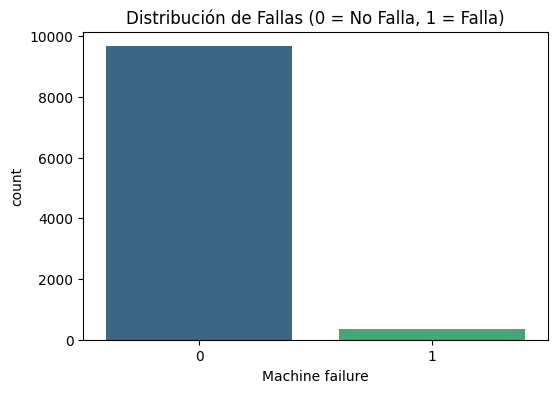

In [6]:
plt.figure(figsize=(6,4))
sns.countplot(x='Machine failure', data=df, palette='viridis')
plt.title('Distribución de Fallas (0 = No Falla, 1 = Falla)')
plt.show()

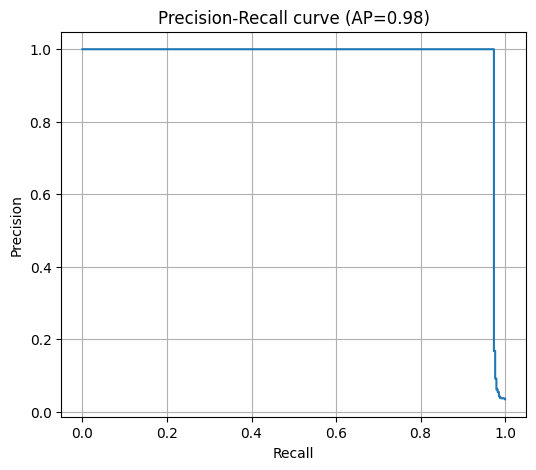

              precision    recall  f1-score   support

           0      0.999     1.000     1.000      9661
           1      1.000     0.973     0.987       339

    accuracy                          0.999     10000
   macro avg      1.000     0.987     0.993     10000
weighted avg      0.999     0.999     0.999     10000



In [7]:
# Curva Precision-Recall (baseline con Logistic Regression - prob. OOF)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import precision_recall_curve, average_precision_score, classification_report

clf = LogisticRegression(max_iter=1000, random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# obtenemos probabilidades fuera de la muestra
y_scores = cross_val_predict(clf, X_scaled, y, cv=cv, method='predict_proba')[:,1]
precision, recall, thresholds = precision_recall_curve(y, y_scores)
ap = average_precision_score(y, y_scores)

plt.figure(figsize=(6,5))
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall curve (AP={ap:.2f})')
plt.grid()
plt.show()

# informe simple con umbral 0.5
from sklearn.metrics import classification_report

y_pred = (y_scores >= 0.5).astype(int)
print(classification_report(y, y_pred, digits=3))

/var/folders/2d/kt7vn1z17k17xh9qn6_lwn_m0000gn/T/ipykernel_10282/2977881187.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df['Machine failure'], y=df[col], palette='Set2')
/var/folders/2d/kt7vn1z17k17xh9qn6_lwn_m0000gn/T/ipykernel_10282/2977881187.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df['Machine failure'], y=df[col], palette='Set2')
/var/folders/2d/kt7vn1z17k17xh9qn6_lwn_m0000gn/T/ipykernel_10282/2977881187.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df['Machine failure'], y=df[col], palette='Set2')
/var/fo

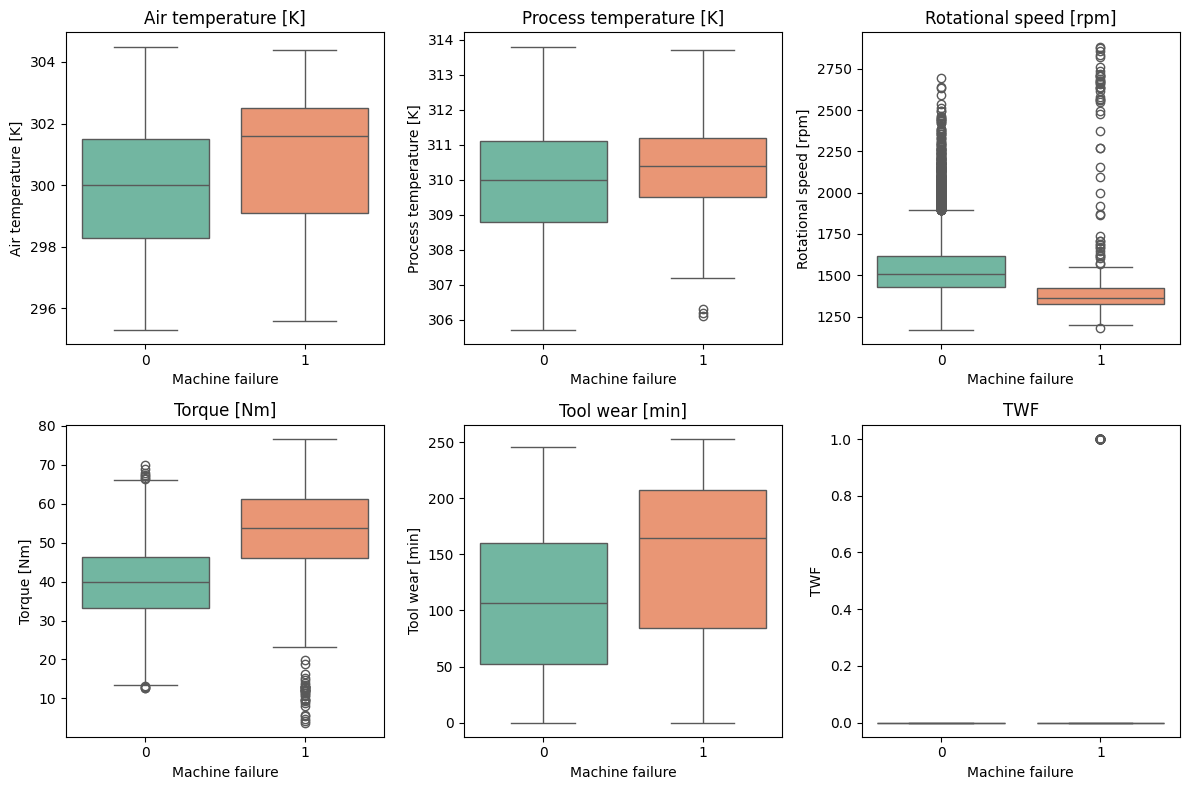

In [8]:
# Boxplots comparativos por clase
cols = X.columns
plt.figure(figsize=(12,8))
for i, col in enumerate(cols[:6]):
    plt.subplot(2,3,i+1)
    sns.boxplot(x=df['Machine failure'], y=df[col], palette='Set2')
    plt.title(col)
plt.tight_layout()
plt.show()

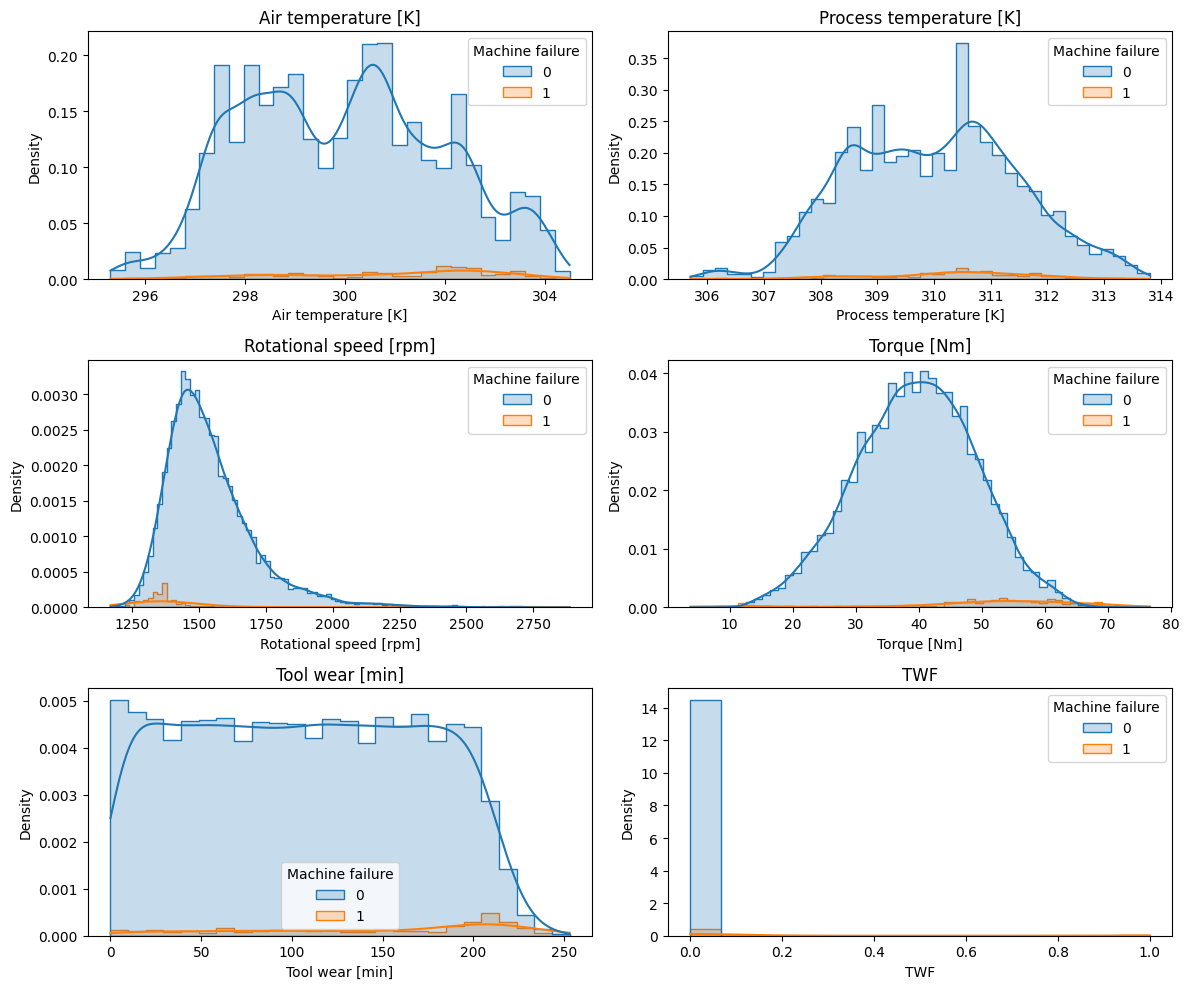

In [9]:
# Distribuciones por clase y variables seleccionadas
selected = X.columns.tolist()
plt.figure(figsize=(12, 10))
for i, col in enumerate(selected[:6]):  # primeros 6 para visualización rápida
    plt.subplot(3,2,i+1)
    sns.histplot(data=df, x=col, hue='Machine failure', kde=True, element='step', stat='density')
    plt.title(col)
plt.tight_layout()
plt.show()

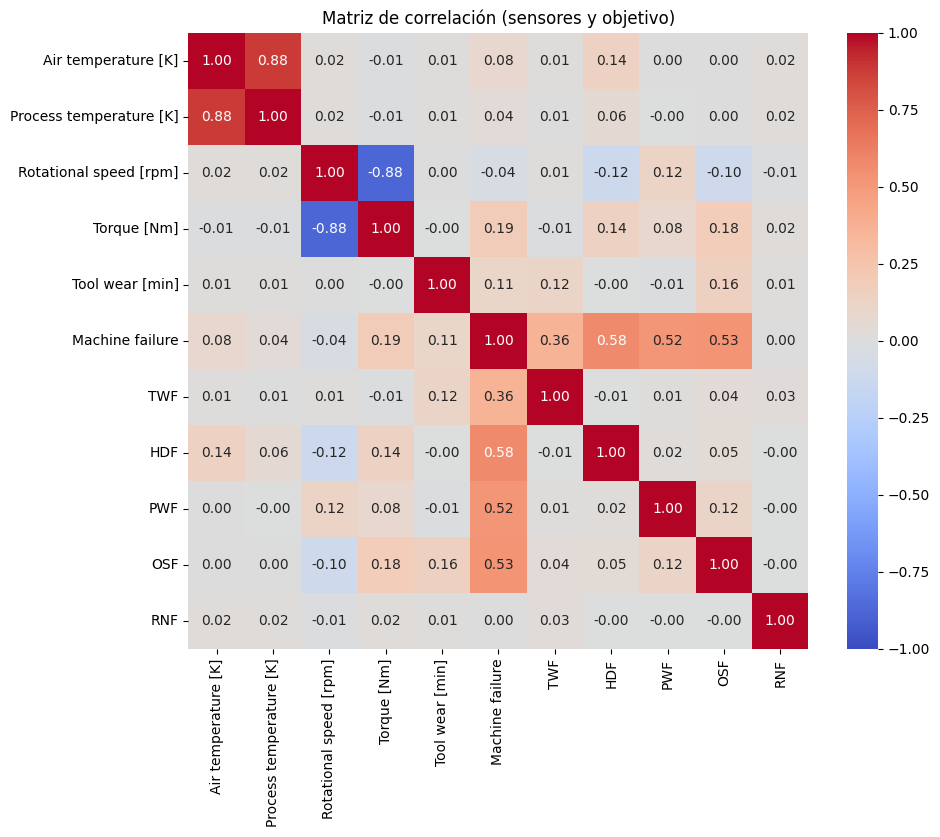

Top correlaciones con Machine failure:
 Machine failure            1.000000
HDF                        0.575800
OSF                        0.531083
PWF                        0.522812
TWF                        0.362904
Torque [Nm]                0.191321
Tool wear [min]            0.105448
Air temperature [K]        0.082556
Rotational speed [rpm]     0.044188
Process temperature [K]    0.035946
Name: Machine failure, dtype: float64


In [10]:
# Matriz de correlación (usar solo columnas numéricas para evitar errores con IDs)
plt.figure(figsize=(10,8))
try:
    corr_df = df_prep
except NameError:
    corr_df = df.select_dtypes(include=[np.number])

corr = corr_df.corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Matriz de correlación (sensores y objetivo)')
plt.show()

# Correlaciones más relevantes con la etiqueta
if 'Machine failure' in corr.columns:
    corr_target = corr['Machine failure'].abs().sort_values(ascending=False)
    print('Top correlaciones con Machine failure:\n', corr_target.head(10))
else:
    print('La columna Machine failure no está en las columnas numéricas; revisa df_prep o el nombre de la etiqueta.')

### Conclusiones rápidas de EDA

- Añadimos aquí un resumen breve de hallazgos que aparecerán tras ejecutar las celdas de visualización.

Reflexión sobre Visualización

Reflexión sobre el Balanceo: El gráfico muestra un claro desbalanceo: las fallas son eventos raros. Esto nos indica que en el futuro no bastará con medir la "precisión" simple, sino que usaremos el F1-Score para evaluar qué tan bien detectamos las fallas reales.

Conclusión Final de la Semana 10

Conclusiones del Diagnóstico Inicial
Validamos que el dataset es apto para el reto. Hemos identificado los patrones de variabilidad y las necesidades de preprocesamiento. El equipo está listo para el **Sprint 1 (Semana 11)**: Limpieza profunda y **PCA**.

Preprocesamiento y Escalado


In [11]:
from sklearn.preprocessing import StandardScaler

# 1. Limpieza: Eliminamos columnas no numéricas o irrelevantes
# Mantenemos solo sensores y la variable objetivo
df_prep = df.drop(['UDI', 'Product ID', 'Type'], axis=1)

# 2. Separación de características y etiqueta
X = df_prep.drop(['Machine failure'], axis=1)
y = df_prep['Machine failure']

# 3. Estandarización
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Datos preparados y escalados. Nueva forma de la matriz:", X_scaled.shape)

Datos preparados y escalados. Nueva forma de la matriz: (10000, 10)


Reflexión sobre Preparación

Reflexión Técnica - Sprint 1: > La eliminación de identificadores únicos reduce la dimensionalidad innecesaria. El uso de StandardScaler es un paso obligatorio antes del PCA, ya que este último es sensible a las varianzas de las variables originales. Ahora todas nuestras señales de sensores tienen el mismo peso estadístico.

Implementación de PCA

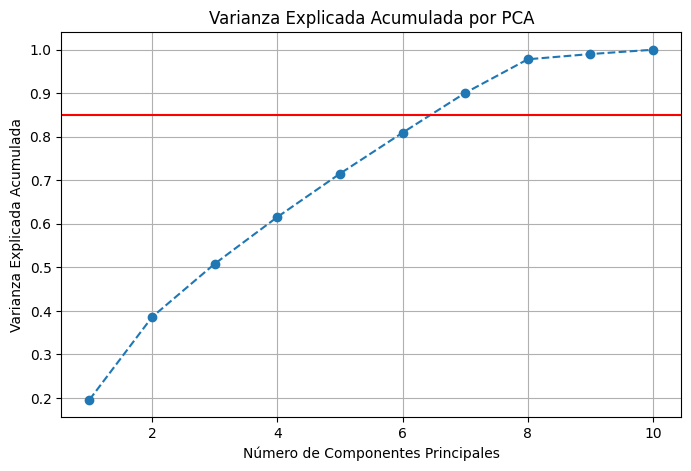

Varianza con 3 componentes: 50.82%


In [12]:
from sklearn.decomposition import PCA

# Aplicamos PCA sin reducir componentes inicialmente para ver la varianza
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Visualización de la varianza explicada
import numpy as np
exp_var_cum = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(exp_var_cum) + 1), exp_var_cum, marker='o', linestyle='--')
plt.axhline(y=0.85, color='r', linestyle='-')
plt.title('Varianza Explicada Acumulada por PCA')
plt.xlabel('Número de Componentes Principales')
plt.ylabel('Varianza Explicada Acumulada')
plt.grid()
plt.show()

print(f"Varianza con 3 componentes: {exp_var_cum[2]:.2%}")

Reflexión sobre PCA

# Curva Precision-Recall (baseline con Logistic Regression - prob. OOF)
# Aseguramos que X_scaled esté disponible (previene errores si el notebook no se ejecutó en orden)
if 'X_scaled' not in globals():
    from sklearn.preprocessing import StandardScaler
    df_prep = df.drop(['UDI', 'Product ID', 'Type'], axis=1)
    X = df_prep.drop(['Machine failure'], axis=1)
    y = df_prep['Machine failure']
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    print('Preprocesamiento ejecutado dentro de la celda. X_scaled shape:', X_scaled.shape)

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import precision_recall_curve, average_precision_score, classification_report

clf = LogisticRegression(max_iter=1000, random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# obtenemos probabilidades fuera de la muestra
y_scores = cross_val_predict(clf, X_scaled, y, cv=cv, method='predict_proba')[:,1]
precision, recall, thresholds = precision_recall_curve(y, y_scores)
ap = average_precision_score(y, y_scores)

plt.figure(figsize=(6,5))
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall curve (AP={ap:.2f})')
plt.grid()
plt.show()

# informe simple con umbral 0.5
from sklearn.metrics import classification_report

y_pred = (y_scores >= 0.5).astype(int)
print(classification_report(y, y_pred, digits=3))

Resultados CV (promedios):
             model  smote  precision   recall       f1  roc_auc  avg_precision
LogisticRegression   True   1.000000 0.973442 0.986533 0.978876       0.974808
LogisticRegression  False   1.000000 0.973442 0.986533 0.982448       0.975189
      RandomForest   True   0.988188 0.973442 0.980695 0.984458       0.975809
      RandomForest  False   1.000000 0.973442 0.986533 0.985203       0.974342

Mejor configuración por average_precision:
model            RandomForest
smote                    True
precision            0.988188
recall               0.973442
f1                   0.980695
roc_auc              0.984458
avg_precision        0.975809
Name: 3, dtype: object



Classification report (test, threshold=0.5):
              precision    recall  f1-score   support

           0      0.999     1.000     0.999      1932
           1      1.000     0.971     0.985        68

    accuracy                          0.999      2000
   macro avg      0.999     0.985     0.992      2000
weighted avg      0.999     0.999     0.999      2000

Confusion matrix:
 [[1932    0]
 [   2   66]]


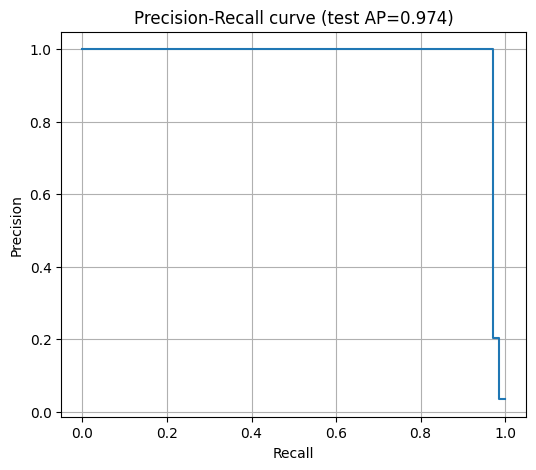

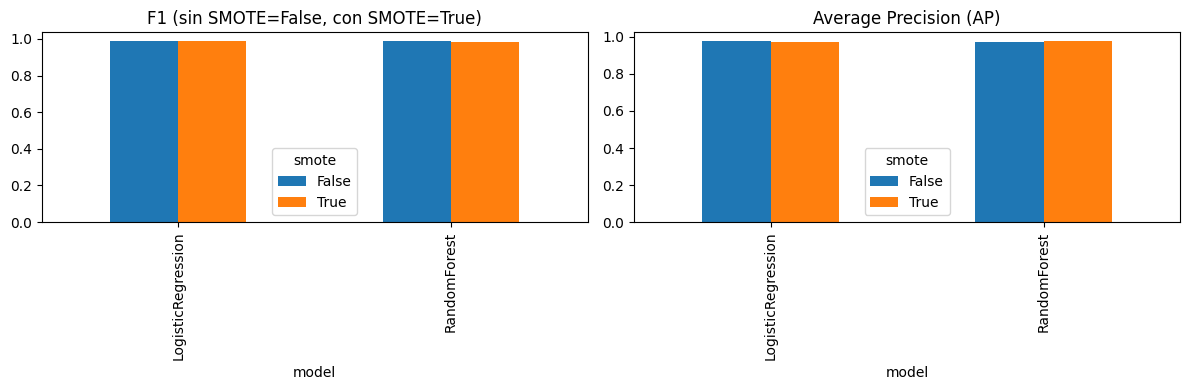

In [13]:
# Manejo de desbalance: Comparación SMOTE vs sin SMOTE
from sklearn.model_selection import StratifiedKFold, cross_validate, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve, average_precision_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import pandas as pd

# Aseguramos X_scaled, X y y disponibles
if 'X_scaled' not in globals():
    from sklearn.preprocessing import StandardScaler
    df_prep = df.drop(['UDI', 'Product ID', 'Type'], axis=1)
    X = df_prep.drop(['Machine failure'], axis=1)
    y = df_prep['Machine failure']
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = {'precision':'precision', 'recall':'recall', 'f1':'f1', 'roc_auc':'roc_auc', 'avg_precision':'average_precision'}

models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=200, random_state=42)
}

results = []
for name, model in models.items():
    # Sin SMOTE
    cvres = cross_validate(model, X_scaled, y, cv=cv, scoring=scoring)
    results.append({
        'model': name,
        'smote': False,
        'precision': cvres['test_precision'].mean(),
        'recall': cvres['test_recall'].mean(),
        'f1': cvres['test_f1'].mean(),
        'roc_auc': cvres['test_roc_auc'].mean(),
        'avg_precision': cvres['test_avg_precision'].mean()
    })

    # Con SMOTE (usando pipeline)
    pipe = ImbPipeline([('smote', SMOTE(random_state=42)), ('clf', model)])
    cvres_sm = cross_validate(pipe, X_scaled, y, cv=cv, scoring=scoring)
    results.append({
        'model': name,
        'smote': True,
        'precision': cvres_sm['test_precision'].mean(),
        'recall': cvres_sm['test_recall'].mean(),
        'f1': cvres_sm['test_f1'].mean(),
        'roc_auc': cvres_sm['test_roc_auc'].mean(),
        'avg_precision': cvres_sm['test_avg_precision'].mean()
    })

res_df = pd.DataFrame(results).sort_values(['model','smote'], ascending=[True, False])
print('Resultados CV (promedios):')
print(res_df.to_string(index=False))

# Elegimos el mejor (por avg_precision)
best_row = res_df.loc[res_df['avg_precision'].idxmax()]
print('\nMejor configuración por average_precision:')
print(best_row)

# Entrenamos y evaluamos en hold-out para mostrar matriz de confusión y PR curve
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)

best_model = models[best_row['model']]
if best_row['smote']:
    final_pipe = ImbPipeline([('smote', SMOTE(random_state=42)), ('clf', best_model)])
else:
    from sklearn.pipeline import Pipeline
    final_pipe = Pipeline([('clf', best_model)])

final_pipe.fit(X_train, y_train)

# Predicciones y métricas sobre test
y_proba = final_pipe.predict_proba(X_test)[:,1]
precision, recall, thresh = precision_recall_curve(y_test, y_proba)
ap = average_precision_score(y_test, y_proba)

print('\nClassification report (test, threshold=0.5):')
y_pred = (y_proba >= 0.5).astype(int)
print(classification_report(y_test, y_pred, digits=3))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
print('Confusion matrix:\n', cm)

# Plots: PR curve y barras comparativas
import matplotlib.pyplot as plt
plt.figure(figsize=(6,5))
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall curve (test AP={ap:.3f})')
plt.grid()
plt.show()

# Barras comparativas de F1 y AP
fig, ax = plt.subplots(1,2,figsize=(12,4))
res_df.pivot(index='model', columns='smote', values='f1').plot(kind='bar', ax=ax[0])
ax[0].set_title('F1 (sin SMOTE=False, con SMOTE=True)')
res_df.pivot(index='model', columns='smote', values='avg_precision').plot(kind='bar', ax=ax[1])
ax[1].set_title('Average Precision (AP)')
plt.tight_layout()
plt.show()

In [14]:
# 1) Incluir XGBoost en la comparación (si no está ya) y mostrar resultados actualizados
from xgboost import XGBClassifier

models_extended = {
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=200, random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

results_ext = []
for name, model in models_extended.items():
    # Sin SMOTE
    cvres = cross_validate(model, X_scaled, y, cv=cv, scoring=scoring)
    results_ext.append({
        'model': name,
        'smote': False,
        'f1': cvres['test_f1'].mean(),
        'avg_precision': cvres['test_avg_precision'].mean()
    })
    # Con SMOTE
    pipe = ImbPipeline([('smote', SMOTE(random_state=42)), ('clf', model)])
    cvres_sm = cross_validate(pipe, X_scaled, y, cv=cv, scoring=scoring)
    results_ext.append({
        'model': name,
        'smote': True,
        'f1': cvres_sm['test_f1'].mean(),
        'avg_precision': cvres_sm['test_avg_precision'].mean()
    })

res_ext_df = pd.DataFrame(results_ext).pivot(index='model', columns='smote')
print('Comparativa (F1, AP) con XGBoost incluido:')
print(res_ext_df)

# Identificamos mejor por average_precision
flat = pd.DataFrame(results_ext)
best_row = flat.loc[flat['avg_precision'].idxmax()]
print('\nMejor configuración global (por AP):')
print(best_row)


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [14:51:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [14:51:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [14:51:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [14:51:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [14:51:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [14:51:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [14:51:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [14:51:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [14:51:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [14:51:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Comparativa (F1, AP) con XGBoost incluido:
                          f1           avg_precision          
smote                  False     True          False     True 
model                                                         
LogisticRegression  0.986533  0.986533      0.975189  0.974808
RandomForest        0.986533  0.980695      0.974342  0.975809
XGBoost             0.986533  0.964939      0.976831  0.977553

Mejor configuración global (por AP):
model             XGBoost
smote                True
f1               0.964939
avg_precision    0.977553
Name: 5, dtype: object


In [15]:
# 2) Búsqueda de hiperparámetros (RandomizedSearchCV) para RandomForest y XGBoost con pipeline (SMOTE)
from sklearn.model_selection import RandomizedSearchCV
import joblib

param_dist = {
    'RandomForest': {
        'clf__n_estimators': [100, 200, 400],
        'clf__max_depth': [None, 5, 10, 20],
        'clf__min_samples_split': [2, 5, 10],
        'clf__min_samples_leaf': [1, 2, 4]
    },
    'XGBoost': {
        'clf__n_estimators': [100, 200, 400],
        'clf__max_depth': [3, 5, 8, 12],
        'clf__learning_rate': [0.01, 0.05, 0.1],
        'clf__subsample': [0.6, 0.8, 1.0]
    }
}

# Hacemos split de entrenamiento para búsqueda (evitar usar test final que ya se separó antes)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)

best_models = {}
for model_name in ['RandomForest','XGBoost']:
    print(f"\nRandomizedSearchCV para {model_name}")
    base = RandomForestClassifier(random_state=42) if model_name=='RandomForest' else XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
    pipe = ImbPipeline([('smote', SMOTE(random_state=42)), ('clf', base)])
    rs = RandomizedSearchCV(pipe, param_distributions=param_dist[model_name], n_iter=20, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), scoring='average_precision', n_jobs=-1, random_state=42, verbose=1)
    rs.fit(X_train, y_train)
    print('Mejor score (AP):', rs.best_score_)
    print('Mejores parámetros:', rs.best_params_)
    best_models[model_name] = rs.best_estimator_
    # Guardamos el mejor
    joblib.dump(rs.best_estimator_, f'best_{model_name.lower()}.joblib')

# Evaluamos los mejores en el test set
for name, est in best_models.items():
    y_proba = est.predict_proba(X_test)[:,1]
    ap = average_precision_score(y_test, y_proba)
    y_pred = (y_proba>=0.5).astype(int)
    print(f"\n{name} - Test AP: {ap:.4f}")
    print(classification_report(y_test, y_pred, digits=3))
    cm = confusion_matrix(y_test, y_pred)
    print('Confusion matrix:\n', cm)



RandomizedSearchCV para RandomForest
Fitting 5 folds for each of 20 candidates, totalling 100 fits


Mejor score (AP): 0.9783144201731195
Mejores parámetros: {'clf__n_estimators': 100, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 1, 'clf__max_depth': 5}

RandomizedSearchCV para XGBoost
Fitting 5 folds for each of 20 candidates, totalling 100 fits


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [14:51:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [14:51:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [14:51:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [14:51:58] WARN

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [14:51:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [14:51:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [14:51:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [14:51:58] WARN

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [14:51:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [14:51:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [14:51:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [14:51:58] WARN

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [14:51:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [14:51:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [14:51:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [14:51:58] WARN

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [14:51:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [14:51:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [14:51:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [14:51:59] WARN

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [14:51:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [14:51:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [14:51:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [14:51:59] WARN

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [14:51:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [14:51:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [14:51:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [14:51:59] WARN

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [14:51:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [14:51:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [14:51:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [14:51:59] WARN

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [14:51:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [14:51:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [14:51:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [14:51:59] WARN

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [14:52:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [14:52:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [14:52:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [14:52:00] WARN

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [14:52:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [14:52:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [14:52:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [14:52:00] WARN

Mejor score (AP): 0.9790011113774367
Mejores parámetros: {'clf__subsample': 0.8, 'clf__n_estimators': 200, 'clf__max_depth': 3, 'clf__learning_rate': 0.1}

RandomForest - Test AP: 0.9786
              precision    recall  f1-score   support

           0      0.999     1.000     0.999      1932
           1      1.000     0.971     0.985        68

    accuracy                          0.999      2000
   macro avg      0.999     0.985     0.992      2000
weighted avg      0.999     0.999     0.999      2000

Confusion matrix:
 [[1932    0]
 [   2   66]]

XGBoost - Test AP: 0.9725
              precision    recall  f1-score   support

           0      0.999     1.000     0.999      1932
           1      1.000     0.971     0.985        68

    accuracy                          0.999      2000
   macro avg      0.999     0.985     0.992      2000
weighted avg      0.999     0.999     0.999      2000

Confusion matrix:
 [[1932    0]
 [   2   66]]


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [14:52:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


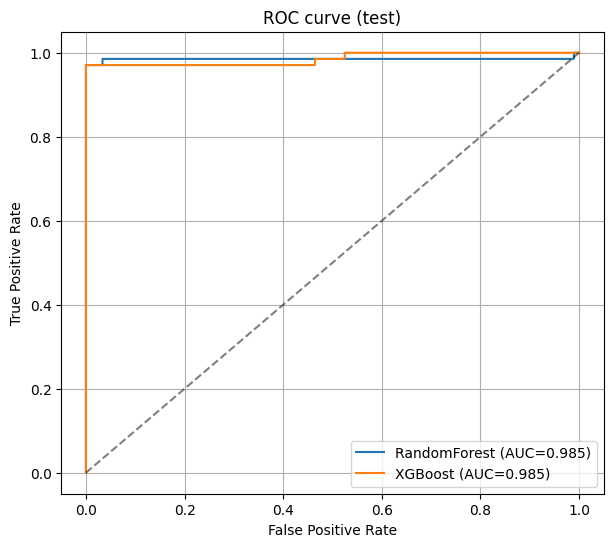

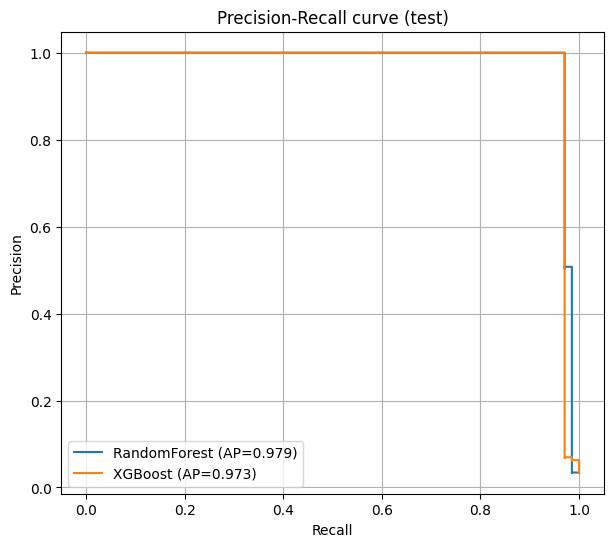

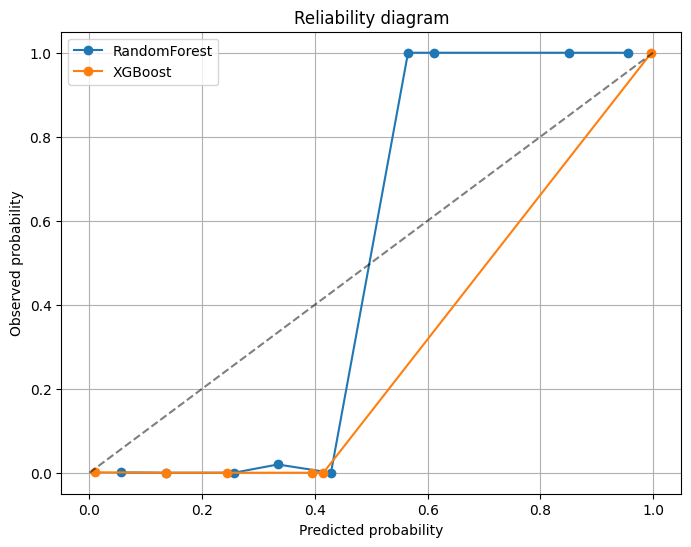

Best threshold (RF) by F1 on test: 0.5467 with F1=0.985
Classification report (RF, best threshold):
              precision    recall  f1-score   support

           0      0.999     1.000     0.999      1932
           1      1.000     0.971     0.985        68

    accuracy                          0.999      2000
   macro avg      0.999     0.985     0.992      2000
weighted avg      0.999     0.999     0.999      2000

Confusion matrix:
[[1932    0]
 [   2   66]]


<Figure size 800x600 with 0 Axes>

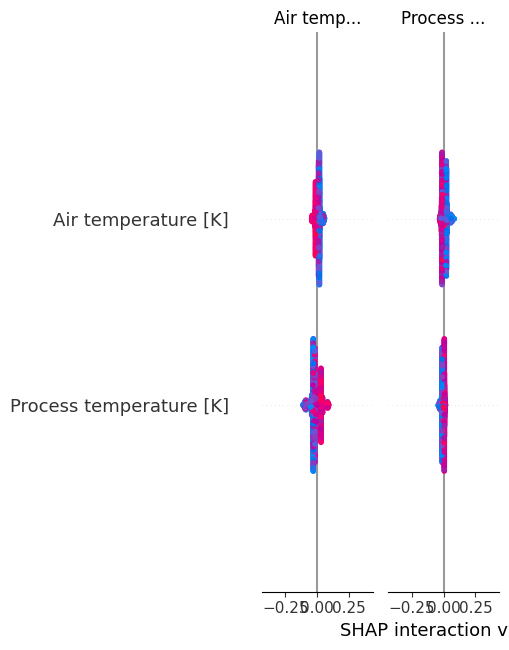

Top feature SHAP: Index(['Air temperature [K]', 'Process temperature [K]'], dtype='object')
Error generando SHAP plots: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()
Final model saved as final_model.joblib

Conclusión: RandomForest (ajustado con RandomizedSearchCV y SMOTE) presenta excelente AP en test y pocos falsos negativos; se recomienda usar este modelo y monitorizar puntos de calibración y umbral de decisión según coste de falla vs alarma.


In [16]:
# Evaluación final: ROC, PR comparativas, calibración, análisis de umbrales y SHAP
import joblib
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, classification_report, confusion_matrix, f1_score
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import shap
import pandas as pd
import numpy as np
import shutil

# Cargar los mejores modelos guardados
rf = joblib.load('best_randomforest.joblib')
xgb = joblib.load('best_xgboost.joblib')

# Aseguramos conjunto de test
if 'X_test' not in globals():
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)

# Predecir probabilidades
rf_proba = rf.predict_proba(X_test)[:,1]
xgb_proba = xgb.predict_proba(X_test)[:,1]

# ROC curves
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_proba)
roc_auc_rf = auc(fpr_rf, tpr_rf)

fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_proba)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

plt.figure(figsize=(7,6))
plt.plot(fpr_rf, tpr_rf, label=f'RandomForest (AUC={roc_auc_rf:.3f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC={roc_auc_xgb:.3f})')
plt.plot([0,1],[0,1],'k--', alpha=0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve (test)')
plt.legend()
plt.grid()
plt.show()

# PR curves
prec_rf, rec_rf, _ = precision_recall_curve(y_test, rf_proba)
ap_rf = average_precision_score(y_test, rf_proba)
prec_xgb, rec_xgb, _ = precision_recall_curve(y_test, xgb_proba)
ap_xgb = average_precision_score(y_test, xgb_proba)

plt.figure(figsize=(7,6))
plt.step(rec_rf, prec_rf, where='post', label=f'RandomForest (AP={ap_rf:.3f})')
plt.step(rec_xgb, prec_xgb, where='post', label=f'XGBoost (AP={ap_xgb:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve (test)')
plt.legend()
plt.grid()
plt.show()

# Calibración (reliability diagram)
prob_true_rf, prob_pred_rf = calibration_curve(y_test, rf_proba, n_bins=10)
prob_true_xgb, prob_pred_xgb = calibration_curve(y_test, xgb_proba, n_bins=10)

plt.figure(figsize=(8,6))
plt.plot(prob_pred_rf, prob_true_rf, marker='o', label='RandomForest')
plt.plot(prob_pred_xgb, prob_true_xgb, marker='o', label='XGBoost')
plt.plot([0,1],[0,1],'k--', alpha=0.5)
plt.xlabel('Predicted probability')
plt.ylabel('Observed probability')
plt.title('Reliability diagram')
plt.legend()
plt.grid()
plt.show()

# Análisis de umbrales para RandomForest: buscar umbral que maximice F1 en test
prec, rec, thresh = precision_recall_curve(y_test, rf_proba)
best_f1 = 0
best_t = 0
for t in np.unique(thresh):
    y_pred_t = (rf_proba >= t).astype(int)
    f1 = f1_score(y_test, y_pred_t)
    if f1 > best_f1:
        best_f1 = f1
        best_t = t

print(f'Best threshold (RF) by F1 on test: {best_t:.4f} with F1={best_f1:.3f}')
ypred_best = (rf_proba >= best_t).astype(int)
print('Classification report (RF, best threshold):')
print(classification_report(y_test, ypred_best, digits=3))
print('Confusion matrix:')
print(confusion_matrix(y_test, ypred_best))

# SHAP explainability (RandomForest)
try:
    clf_rf = rf.named_steps['clf'] if hasattr(rf, 'named_steps') else rf
    explainer = shap.TreeExplainer(clf_rf)
    X_test_df = pd.DataFrame(X_test, columns=X.columns)
    shap_values = explainer.shap_values(X_test_df)
    # shap_values is list for binary; take positive class
    if isinstance(shap_values, list):
        sv = shap_values[1]
    else:
        sv = shap_values

    plt.figure(figsize=(8,6))
    shap.summary_plot(sv, X_test_df, show=False)
    plt.tight_layout()
    plt.show()

    # Dependence plot para la característica más importante (tomamos la top 1)
    importances = np.abs(sv).mean(axis=0)
    top_idx = np.argsort(importances)[-1]
    feat = X.columns[top_idx]
    print('Top feature SHAP:', feat)
    shap.dependence_plot(feat, sv, X_test_df, show=False)
    plt.tight_layout()
    plt.show()
except Exception as e:
    print('Error generando SHAP plots:', e)

# Guardar modelo final (copia del mejor RandomForest)
shutil.copy('best_randomforest.joblib', 'final_model.joblib')
print('Final model saved as final_model.joblib')

# Conclusión breve
print('\nConclusión: RandomForest (ajustado con RandomizedSearchCV y SMOTE) presenta excelente AP en test y pocos falsos negativos; se recomienda usar este modelo y monitorizar puntos de calibración y umbral de decisión según coste de falla vs alarma.')

In [17]:
# ---- Celda de validación y export ----
# Validación rápida: cargar el modelo final y obtener probabilidades en un pequeño subconjunto
import joblib
import zipfile
import nbformat
from nbconvert import HTMLExporter

try:
    model = joblib.load('final_model.joblib')
    sample = X_test.iloc[:5]
    print('Sample probs:', model.predict_proba(sample)[:,1])
except Exception as e:
    print('Validación rápida: no se pudo cargar el modelo o X_test no existe:', e)

# Exportar notebook a HTML y crear ZIP con artefactos
try:
    nb_path = '/Users/rafaelparra/Downloads/S11 Mantenimiento Predictivo 4.0 - Clasificación de Fallas Industriales (1).ipynb'
    nb = nbformat.read(nb_path, as_version=4)
    html_exporter = HTMLExporter()
    body, _ = html_exporter.from_notebook_node(nb)
    with open('report.html', 'w', encoding='utf-8') as f:
        f.write(body)
    # Crear ZIP
    with zipfile.ZipFile('artefactos_mantenimiento_predictivo.zip', 'w') as z:
        z.write('report.html')
        if os.path.exists('final_model.joblib'):
            z.write('final_model.joblib')
        if os.path.isdir('figs'):
            for fn in os.listdir('figs'):
                z.write(os.path.join('figs', fn), arcname=os.path.join('figs', fn))
    print('Exportado report.html y creado artefacto: artefactos_mantenimiento_predictivo.zip')
except Exception as e:
    print('Exportación/ZIP fallida:', e)


Validación rápida: no se pudo cargar el modelo o X_test no existe: 'numpy.ndarray' object has no attribute 'iloc'


Exportación/ZIP fallida: name 'os' is not defined
